In [169]:

using Pkg
Pkg.activate("./baron_env")
#Pkg.pin("JuMP")

using JuMP
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using BARON

  Activating environment at `~/Documents/project-codes/Plan_RoadmapsIAM/toy-problem/baron_env/Project.toml`


In [170]:
innovations = CSV.File("./innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]
initial
innovations[2,6]=7
#innovations[2,3]=2
#innovations[2,2]=142
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,7.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [171]:
Pkg.installed()

┌ Warning: Pkg.installed() is deprecated
└ @ Pkg /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Pkg/src/Pkg.jl:570


Dict{String, VersionNumber} with 2 entries:
  "BARON" => v"0.6.5"
  "CPLEX" => v"0.7.8"

In [172]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat'
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_rate_eig_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return [q_mat,eigvecs(q_mat),eigvals(q_mat)]
end

function get_IAM_factor(t)
    return 1
end

function give_sorted(t)
    v=sortperm(t)
    return v
end

function calc_tot_co2(x,t)
    v=give_sorted(t)
    for i in 1:(size(tk)[1]-1)
        print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
        print("\n")
    end
    return 1
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    #rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    rl_t=sum([1 2 3 4 5].*(s0*d))
    return rl_t
end

function get_RL_DTMC(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    rl_t=sum([1 2 3 4 5].*(s0*p_mat^t))
    return rl_t
end
    
    


get_RL_DTMC (generic function with 1 method)

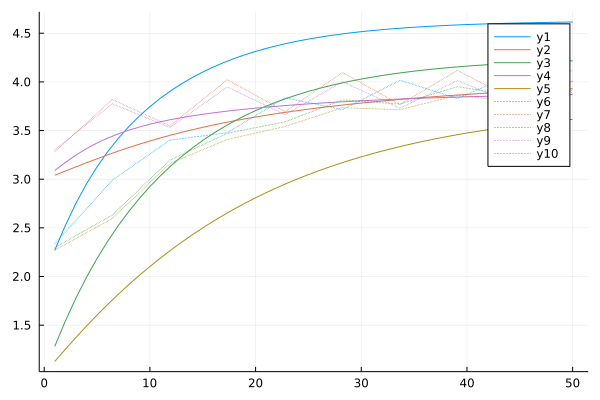

In [173]:
get_RL_atT(4,25)
pal = palette(:default)
plot([get_RL_atT.(i, 1:50) for i = 1:5]; color = [pal[i] for i = 1:5]')
plot!(range(1, 50; length = 10), [get_RL_DTMC.(i, 1:10) for i = 1:5], linestyle = :dot, color = pal[1:5]')

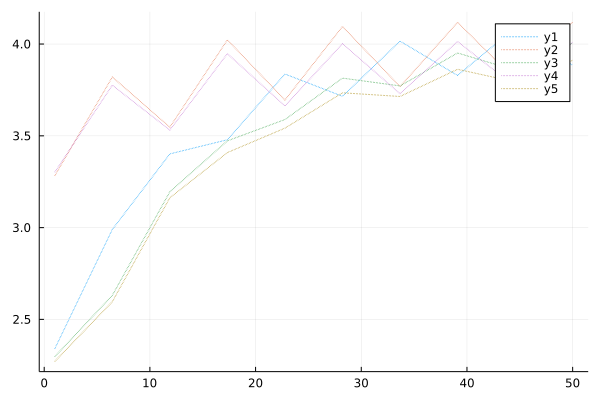

In [174]:

plot(range(1, 50; length = 10),[get_RL_DTMC.(i,1:10) for i = 1:5], linestyle = :dot, color = [pal[i] for i = 1:5]')

In [177]:
q=zeros(5,5,nrow(innovations))
a=zeros(5,5,nrow(innovations))
ainv=zeros(5,5,nrow(innovations))
d=zeros(5,1,nrow(innovations))
s0=zeros(1,5,nrow(innovations))
for i in 1:nrow(innovations)
    q[:,:,i]=round.(get_rate_eig_mat(i)[1],sigdigits=3)
    a[:,:,i]=(get_rate_eig_mat(i)[2])
    d[:,:,i]=round.(get_rate_eig_mat(i)[3],sigdigits=3)
    ainv[:,:,i]=round.(inv(get_rate_eig_mat(i)[2]),sigdigits=3)
    s0[1,rl[i],i]=1
end

In [31]:
function tech_roadmap()
    rdmap= Model(BARON.Optimizer)
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    @variable(rdmap, 1 ≤ s[i=1:nrow(innovations)])
    
    
    @variable(rdmap, co2_2050 ≥ 0)
    @variable(rdmap, co2_total ≥ 0)
    @variable(rdmap, cost_inn≥ 0)
    
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    @constraint(rdmap, [i=1,k=1:mapki[i,2]], ti[i] ≤ tk[k])
    @constraint(rdmap, [i=2:nrow(mapki),k=mapki[i-1,2]:mapki[i,2]], ti[i] ≤ tk[k])
    
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3]*get_IAM_factor(tk[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    #@constraint(rdmap, co2_total == calc_tot_co2(xk,tk))
    register(rdmap, :get_RL_atT,2,get_RL_atT;autodiff=true)
    register(rdmap, :get_transition_mat,1,get_transition_mat;autodiff=true)
    register(rdmap, :get_rate_mat,1,get_rate_mat;autodiff=true)
    register(rdmap, :get_RL,2,get_RL;autodiff=true)
    

    @NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==get_RL(i,ti[i]))
    
    @constraint(rdmap, co2_2050 ≤ 75)
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(5-s[i])) for i in 1:nrow(innovations)))
    
    
    @NLobjective(rdmap,Min, cost_inn)
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn)  
end



LoadError: syntax: "function" at In[31]:1 expected "end", got "for"

In [186]:
function tech_roadmap()
    
    rdmap= Model(BARON.Optimizer)
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    @variable(rdmap, 1 ≤ s[i=1:nrow(innovations)] )
    
    @variable(rdmap, co2_2050 ≥ 0)
    @variable(rdmap, co2_total ≥ 0)
    @variable(rdmap, cost_inn≥ 0)
    
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    @constraint(rdmap, [i=1,k=1:mapki[i,2]], ti[i] ≤ tk[k])
    @constraint(rdmap, [i=2:nrow(mapki),k=mapki[i-1,2]:mapki[i,2]], ti[i] ≤ tk[k])
    
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3]*get_IAM_factor(tk[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    
    
    #@NLparameter(rdmap, q[i=1:nrow(innovations)]==0)
    #@NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum([1 2 3 4 5].*((s0[:,:,i]*a[:,:,i]).*(exp.(d[:,:,i]*ti[i]))'*ainv[:,:,i])[ind] for ind in 1:5))
    @NLconstraint(rdmap, [i=1:nrow(innovations)], s[i]==sum([1 2 3 4 5].*((s0[:,:,i]*a[:,:,i]).*(exp.(d[:,:,i]*ti[i]))'*ainv[:,:,i])[ind] for ind in 1:5))    
    
    
    @constraint(rdmap, co2_2050 ≤ 75)
    @NLconstraint(rdmap, cost_inn == sum(ci[i]*(yi[i]*(5-s[i])) for i in 1:nrow(innovations)))
    @NLobjective(rdmap,Min, cost_inn)
    
    optimize!(rdmap)
    return JuMP.value.(yk), JuMP.value.(tk), JuMP.value.(xk), JuMP.value.(yi), JuMP.value.(ti), JuMP.value.(s), JuMP.value.(co2_2050), JuMP.value.(cost_inn)  
end




tech_roadmap (generic function with 1 method)

([1...5] .* X_{i} * A) = P1_{i} 

@assert det(A^{-1}_{i})

= P2_{i}

mean(P1_{i} .* w_{i.} * P2_{i})

w_{ij} = exp(D_{ji}*t) forall j\in{1,\ldot 5}, i\in{1..5} 

In [187]:
yk, tk, xk, yi, ti, s, co2, cost1=tech_roadmap()
yi

LoadError: Unexpected array [1 2 3 4 5] in nonlinear expression. Nonlinear expressions may contain only scalar expressions.

In [153]:
function get_new1(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    
    temp1=Diagonal(eigvals(q))*t
    temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
    d=eigvecs(q)*(temp2)*inv(eigvecs(q))
    t1=(s0)*eigvecs(q)
    return t1
end
function get_new2(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    q=q_mat
    
    temp1=(eigvals(q))*t
    return temp1
end

function get_new3(i,t)
    s0=[0 0 0 0 0]
    s0[rl[i]]=1
    p_mat=reshape(collect(innovations[i,9:33]),5,5)'
    q_mat=p_mat./collect(innovations[i,4:8])
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return inv(eigvecs(q_mat))
end


function get_new(i,t)
    return sum([1 2 3 4 5].*(get_new1(i,t).*round.(exp.(get_new2(i,t)),sigdigits=3)'*get_new3(i,t)))
end
#get_RL(1,50)



i=1
t=50
s0=[0 0 0 0 0]
s0[rl[i]]=1
p_mat=reshape(collect(innovations[i,9:33]),5,5)'
q_mat=p_mat./collect(innovations[i,4:8])
for i in 1:5
    q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
end
q=q_mat
#rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
#rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))
temp1=Diagonal(eigvals(q))*t
temp2=reshape(reduce(vcat,(exp(temp1))),5,5)
d=eigvecs(q)*(temp2)*inv(eigvecs(q))
rl_t=sum([1 2 3 4 5].*(s0*d))
temp2

get_new(4,50)

3.8698053730585023

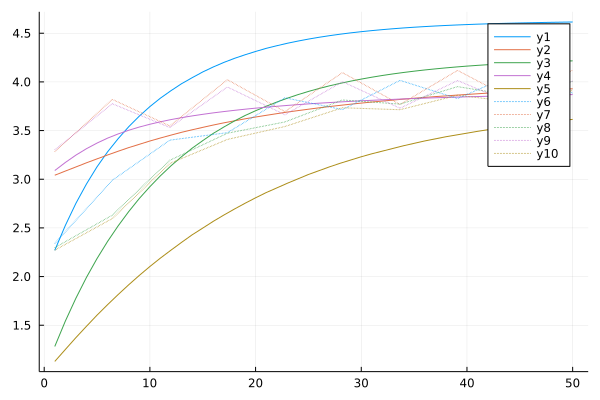

In [155]:
get_RL_atT(4,25)
pal = palette(:default)
plot([get_new.(i, 1:50) for i = 1:5]; color = [pal[i] for i = 1:5]')
plot!(range(1, 50; length = 10), [get_RL_DTMC.(i, 1:10) for i = 1:5], linestyle = :dot, color = pal[1:5]')

In [9]:
ti

LoadError: UndefVarError: ti not defined

In [10]:
yi

LoadError: UndefVarError: yi not defined

In [11]:
co2

LoadError: UndefVarError: co2 not defined

In [12]:
s

LoadError: UndefVarError: s not defined

In [13]:
cost1

LoadError: UndefVarError: cost1 not defined

In [14]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,7.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [42]:
get_RL_atT(4,50)

-41.11305631301775

In [43]:
i=1
eDtmc=[[collect(innovations[i,9:13])],[collect(innovations[i,9:13])]]

2-element Vector{Vector{Vector{Real}}}:
 [[0, 0.76, 0.21, 0.03, 0]]
 [[0, 0.76, 0.21, 0.03, 0]]

In [44]:
innovations[1,9:13]

,P11,P12,P13,P14,P15
,Int64,Float64,Float64,Float64,Int64
1,0,0.76,0.21,0.03,0


In [45]:
collect(innovations[i,9:13])

5-element Vector{Real}:
 0
 0.76
 0.21
 0.03
 0

In [46]:
g=exp(get_rate_mat(2)*50)


5×5 Matrix{Float64}:
 0.0771895  0.128895   0.138814   0.385642  0.269459
 0.0679296  0.114343   0.130868   0.400474  0.286385
 0.0452652  0.0776663  0.109623   0.437398  0.330047
 0.0280624  0.0499089  0.0930683  0.465243  0.363718
 0.0252328  0.0453331  0.0902223  0.46976   0.369452

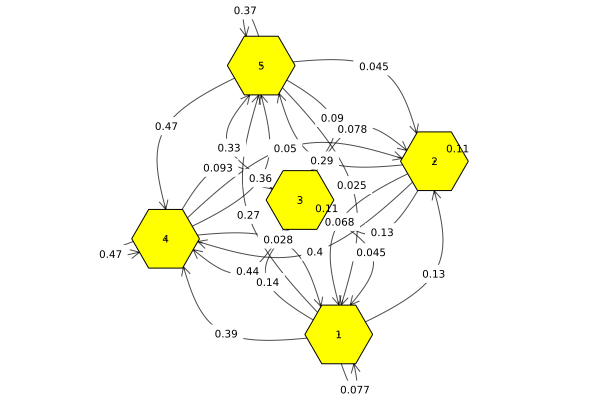

In [101]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)

In [48]:
tt=4
g+tt*g^2/2+tt^3*g^3/6+tt^4*g^4/24

5×5 Matrix{Float64}:
 0.860082  1.49996  2.43039  11.033   8.5099
 0.846386  1.47826  2.41825  11.055   8.53542
 0.812576  1.4236   2.38646  11.11    8.60068
 0.786893  1.38217  2.36188  11.1516  8.65078
 0.782657  1.37533  2.3577   11.1584  8.65924

In [49]:
exp(g*tt)

5×5 Matrix{Float64}:
 2.98448  3.44865  5.43726  24.1562  18.5716
 1.93566  4.37144  5.39434  24.2346  18.6621
 1.8154   3.17698  6.28135  24.4303  18.8941
 1.72406  3.02962  5.19382  25.5782  19.0724
 1.70901  3.0053   5.1789   24.6023  20.1026

In [50]:
tk=vec([1 34 2 112 44])
xk=vec([0.1 0.32 0.2 0.11 0.4])

5-element Vector{Float64}:
 0.1
 0.32
 0.2
 0.11
 0.4

In [51]:
xk[give_sorted(tk)]
v=give_sorted(tk)
v
compromise

,k,i,GWP,Theta,Per_Recycl,Per_Comp
,Int64,Int64,Int64,Float64,Float64,Float64
1,1,1,80,0.6,0.5,0.0
2,2,1,86,0.66,0.55,0.0
3,3,1,91,0.68,0.567,0.0
4,4,1,95,0.7,0.583,0.0
5,5,2,60,0.4,0.0,0.2
6,6,2,64,0.48,0.0,0.24
7,7,2,68,0.5,0.0,0.27
8,8,2,76,0.52,0.0,0.34
9,9,2,80,0.54,0.0,0.37


In [52]:
q=get_rate_mat(2)
t=50
s0=[0 0 0 1 0]
(s0*(exp(q*t)))

1×5 Matrix{Float64}:
 0.0280624  0.0499089  0.0930683  0.465243  0.363718

In [53]:
for i in 1:size(tk)[1]
    print(sum(xk[v[j]] for j in 1:i))
    print("\n")
end

0.1
0.30000000000000004
0.6200000000000001
1.02
1.1300000000000001


In [54]:
size(tk)[1]

5

In [55]:
for i in 1:(size(tk)[1]-1)
    print(initial[1,3]*tk[v][1]-sum(xk[v[j]]*tk[v][j+1]*(initial[1,3]-compromise[v,3][j]) for j in 1:i))
    print("\n")
end

96.0
34.8
-162.32
-1954.3200000000002


In [56]:
apprx=I+get_rate_mat(4)*50

5×5 Matrix{Float64}:
 -8.12409   6.87956     1.78832   0.456204   0.0
  2.42126  -5.56168     3.83202   0.308399   0.0
  1.78144   2.93413   -13.9701    9.49102    0.763473
  0.0       0.405941    1.92079  -8.90099    7.57426
  0.0       0.0         0.0       8.92857   -7.92857

In [57]:
n1=[1 2 3 4 5].*[0 0 1 0 0]*apprx

1×5 Matrix{Float64}:
 5.34431  8.8024  -41.9102  28.4731  2.29042

In [58]:
sum(n1)

3.0000000000000013

In [59]:
i=4
s0=[0 0 0 0 0]
s0[i]=rl[i]
q=get_rate_mat(i)
t=50
apprx=I+q*t+1/2*t^2*q^2

5×5 Matrix{Float64}:
  43.4219   -44.3599     -6.13627     5.66386    2.41037
 -13.1551    29.9792    -34.9618     16.507      2.63077
 -16.1275   -20.6002    114.411    -104.268     27.5842
   2.20233   -0.117564  -21.1875     83.1052   -63.0025
   0.0        1.81223     8.57496   -75.132     65.7448

In [60]:
n1=[1 2 3 4 5].*[0 0 1 0 0]*apprx
sum(n1)

3.000000000000057

In [61]:
get_RL_atT(4,50)

-41.11305631301775

In [62]:
s0

1×5 Matrix{Int64}:
 0  0  0  3  0

In [63]:

i=2
t=50
s0=[0 0 0 0 0]
s0[rl[i]]=1
q=get_rate_mat(i)
#rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q^2)))

8.178628123098022

In [64]:
s0=[0 0.2 0.3 0.4 0.1]
s1=[0 0 0 1 0]

1×5 Matrix{Int64}:
 0  0  0  1  0

In [65]:
s0*(I+t.*q+((1/2)*t^2).*q^2+((1/6)*t^3).*q^3+((1/24)*t^4).*q^4+((1/120)*t^5).*q^5)

1×5 Matrix{Float64}:
 18.7711  -24.5321  5.34423  -7.83121  9.248

In [66]:
(I+t.*q+((1/2)*t^2).*q^2+((1/6)*t^3).*q^3+((1/24)*t^4).*q^4+((1/120)*t^5).*q^5)

5×5 Matrix{Float64}:
 -138.354     241.038    -165.434     67.2842    -3.53511
   66.0809   -182.399     251.702   -234.925    100.541
   31.4691     52.7655   -254.965    436.357   -264.626
  -11.9463    -11.7273     99.6773  -306.575    231.571
    8.92662     8.08954   -83.7745   308.766   -241.008

In [67]:
(I+sum((1/factorial(i))*(t^i)*(q^i) for i in 1:20))

5×5 Matrix{Float64}:
 -94.2609   313.131   -519.969    684.184  -382.085
  25.8329  -239.916    596.533  -1069.33    687.883
  64.8606    87.1085  -543.548   1347.24   -954.662
 -38.9508   -39.9843   304.811   -837.239   612.363
  37.0407    37.7705  -292.265    821.345  -602.892

In [68]:
sum([1 2 3 4 5].*(s0*exp(q*t)))

3.9693414106379463

In [69]:
sum([1 2 3 4 5].*(s0*(exp(q*t))))

3.9693414106379463

In [70]:
q

5×5 Matrix{Float64}:
 -0.120192    0.0930288    0.0227163   0.00444712   0.0
  0.039819   -0.113122     0.0667421   0.00656109   0.0
  0.0168571   0.0287143   -0.142857    0.0918571    0.00542857
  0.0         0.00141414   0.020404   -0.10101      0.0791919
  0.0         0.0          0.0         0.103627    -0.103627

In [71]:
exp(q*50)

5×5 Matrix{Float64}:
 0.0771895  0.128895   0.138814   0.385642  0.269459
 0.0679296  0.114343   0.130868   0.400474  0.286385
 0.0452652  0.0776663  0.109623   0.437398  0.330047
 0.0280624  0.0499089  0.0930683  0.465243  0.363718
 0.0252328  0.0453331  0.0902223  0.46976   0.369452

In [72]:
q

5×5 Matrix{Float64}:
 -0.120192    0.0930288    0.0227163   0.00444712   0.0
  0.039819   -0.113122     0.0667421   0.00656109   0.0
  0.0168571   0.0287143   -0.142857    0.0918571    0.00542857
  0.0         0.00141414   0.020404   -0.10101      0.0791919
  0.0         0.0          0.0         0.103627    -0.103627

In [73]:
eigvals(q)

5-element Vector{Float64}:
 -0.2098085085920511
 -0.17936850177094582
 -0.15160942696594223
 -0.040022229181495284
  2.0816681711721685e-17

In [74]:
eigvecs(q)

5×5 Matrix{Float64}:
 -0.434616   0.838843      0.877579    0.754836   0.447214
  0.537586  -0.543012     -0.194178    0.60145    0.447214
 -0.552263   0.0384604    -0.404635    0.215999   0.447214
  0.333468   0.000561943  -0.0708359  -0.0772814  0.447214
 -0.325445  -0.00076883    0.152983   -0.125909   0.447214

In [75]:
Diagonal(eigvals(q))

5×5 Diagonal{Float64, Vector{Float64}}:
 -0.209809    ⋅          ⋅          ⋅          ⋅ 
   ⋅        -0.179369    ⋅          ⋅          ⋅ 
   ⋅          ⋅        -0.151609    ⋅          ⋅ 
   ⋅          ⋅          ⋅        -0.0400222   ⋅ 
   ⋅          ⋅          ⋅          ⋅         2.08167e-17

In [76]:
s1=[0 0 0 0 0]
s1[rl[i]]=1
s1

1×5 Matrix{Int64}:
 0  0  1  0  0

In [77]:
q=get_rate_mat(2)
d=eigvecs(q)*Diagonal(eigvals(q)*t)*inv(eigvecs(q))
#d=eigvecs(q)*(I+t*Diagonal(eigvals(q)))*inv(eigvecs(q))

5×5 Matrix{Float64}:
 -6.00962       4.65144       1.13582       0.222356   2.58992e-15
  1.99095      -5.65611       3.3371        0.328054  -9.62798e-16
  0.842857      1.43571      -7.14286       4.59286    0.271429
 -8.68107e-16   0.0707071     1.0202       -5.05051    3.9596
 -1.46485e-15  -5.14331e-17   1.04499e-15   5.18135   -5.18135

In [78]:
sum([1 2 3 4 5].*(s1*d))

2.0142857142857187

In [79]:
s1

1×5 Matrix{Int64}:
 0  0  1  0  0

In [80]:
get_RL_atT(1,50)

-13.899832849996947

In [81]:
i=1
q=get_rate_mat(i)
t=50
eigvecs(q)'*(I+t*Diagonal(eigvals(q))+t^2*Diagonal(eigvals(q).^2))*inv(eigvecs(q)')

5×5 Matrix{Float64}:
   24.8037     -30.5065     -20.7009      81.0788        -10.3392
   36.1094   12337.0      16959.0     -32236.3          3609.06
  188.362    26705.1      41500.9     -79407.9          8876.7
 -184.609   -38797.5     -61959.7          1.20847e5  -13593.4
   83.4968   20899.2      33492.6     -65783.5          7418.99

In [82]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,7.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [83]:
get_transition_mat(1)'

5×5 Matrix{Real}:
 0     0.36  0.12  0    0
 0.76  0     0.2   0.0  0
 0.21  0.58  0     0.2  0
 0.03  0.06  0.65  0    1
 0     0     0.03  0.8  0

In [84]:
a=[1 2; 4 3]

2×2 Matrix{Int64}:
 1  2
 4  3

In [85]:
exp(a)

2×2 Matrix{Float64}:
 49.7163  49.3484
 98.6969  99.0647

In [86]:
I+a+(a^2)./2+(a^3)./6+(a^4)./24+(a^5)./120+(a^6)./720+(a^7)./factorial(7)+(a^8)./factorial(8)

2×2 Matrix{Float64}:
 46.3476  45.9798
 91.9595  92.3274

In [87]:
a^2

2×2 Matrix{Int64}:
  9   8
 16  17

In [88]:
get_transition_mat(1)

5×5 adjoint(::Matrix{Real}) with eltype Real:
 0     0.76  0.21  0.03  0
 0.36  0     0.58  0.06  0
 0.12  0.2   0     0.65  0.03
 0     0.0   0.2   0     0.8
 0     0     0     1     0

In [89]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,7.0,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [90]:
get_transition_mat(1)./collect(innovations[1,4:8])

5×5 Matrix{Float64}:
 0.0        0.165217   0.0456522  0.00652174  0.0
 0.268657   0.0        0.432836   0.0447761   0.0
 0.0588235  0.0980392  0.0        0.318627    0.0147059
 0.0        0.0        1.66667    0.0         6.66667
 0.0        0.0        0.0        0.112867    0.0

In [91]:
I+t*Diagonal(eigvals(q))+t^2*Diagonal(eigvals(q).^2)

5×5 Diagonal{Float64, Vector{Float64}}:
 1.79753e5      ⋅       ⋅       ⋅       ⋅ 
  ⋅         1934.58     ⋅       ⋅       ⋅ 
  ⋅             ⋅    419.098    ⋅       ⋅ 
  ⋅             ⋅       ⋅     21.9329   ⋅ 
  ⋅             ⋅       ⋅       ⋅      1.0

In [92]:
exp(50*Diagonal(eigvals(q)))

5×5 Diagonal{Float64, Vector{Float64}}:
 4.51242e-185   ⋅            ⋅            ⋅          ⋅ 
  ⋅            4.83727e-20   ⋅            ⋅          ⋅ 
  ⋅             ⋅           7.94298e-10   ⋅          ⋅ 
  ⋅             ⋅            ⋅           0.0060816   ⋅ 
  ⋅             ⋅            ⋅            ⋅         1.0

In [93]:
eigvals(q)

5-element Vector{Float64}:
 -8.48942815163113
 -0.8895070448628717
 -0.41907123933545865
 -0.10204975415525477
 -4.885048420854648e-17

In [94]:
t=50
1+sum((1/factorial(i))*t^i*(8.5)^i for i in 1:20)

3.366441526732466e21